In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import matplotlib.patches as mpatches

from DataManager import getTrackData, getGenreData, getFeatureData, getEchonestData

In [6]:
# Load The Data
genres = getGenreData()
tracks = getTrackData()

echonest = getEchonestData().echonest
features = getFeatureData()

In [7]:
genre_names = genres[genres.parent == 0].title.values

In [8]:
colors = ["#c2633e", "#7c68e2", "#78d747", "#c54edc",
"#d1d43e", "#dd46a8", "#6bd88a", "#e44c31",
"#4dd4c5", "#da567a", "#5f9140", "#c57dc5",
"#c5d67d", "#648bd5", "#c39438", "#e58f6f"]

genre_colors = dict(zip(genre_names, colors))

In [9]:
# Calculate the Genres of Artists
#   Genres are calculated based off of the top_genre of the tracks
#   The artist genre is the most common genre that they release

artist_genres_raw = pd.concat(
    [tracks['artist']['name'], tracks['track']['genre_top']],
    axis=1, keys=['artist_name', 'genre']
)

artist_genres_raw.dropna(inplace=True)

# Get a count of all the track genres that an artist created
artist_genres = artist_genres_raw.groupby(['artist_name', 'genre'] , sort=False).size().reset_index(name='song_count')
artist_genres.sort_values(by=['artist_name', 'song_count', 'genre'], ascending=False, inplace=True)

# Get the most common genre that an artist created
indecies = artist_genres.groupby('artist_name', sort=False)['song_count'].transform(max) == artist_genres['song_count']
artist_genres = artist_genres[indecies]

artist_genres.drop(columns=['song_count'], inplace=True)
artist_genres.set_index('artist_name', inplace=True)

# Create a genre lookup table for the artists
artist_genre_lookup = artist_genres.to_dict()['genre']

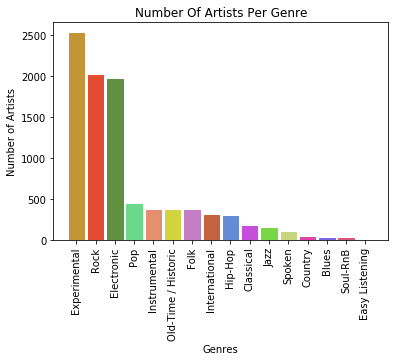

In [10]:
# Plot the number of artists in the top genres

artist_genre_counts = artist_genres['genre'].value_counts().reset_index()
artist_genre_counts.columns = ['genre', 'artist_count']

barlist=plt.bar(artist_genre_counts['genre'], artist_genre_counts['artist_count'])
plt.xticks(rotation='vertical')
plt.title('Number Of Artists Per Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Artists')

for idx, genre in enumerate(artist_genre_counts['genre']):
    barlist[idx].set_color(genre_colors[genre])

plt.show()

In [11]:
# Get the genres for all the tracks in the echonest dataset
echonest_artist_names = echonest.metadata.artist_name
genre_lookup = lambda artist: artist_genre_lookup[artist] if artist in artist_genre_lookup else np.nan

# Apply it to the original data set
echonest['genre'] = echonest_artist_names.apply(genre_lookup)

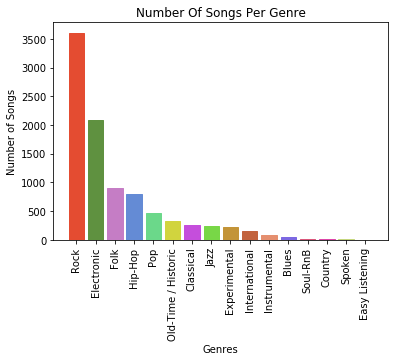

In [24]:
echonest_genre_counts = echonest.genre.value_counts().reset_index()
echonest_genre_counts.columns = ['genre', 'song_count']

barlist=plt.bar(echonest_genre_counts.genre, echonest_genre_counts.song_count)
plt.xticks(rotation='90')
plt.title('Number Of Songs Per Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Songs')

for idx, genre in enumerate(echonest_genre_counts['genre']):
    barlist[idx].set_color(genre_colors[genre])

plt.show()

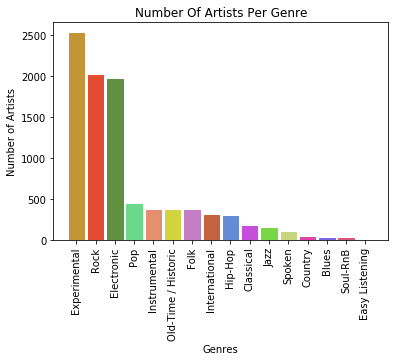

In [13]:
# Plot the number of artists in the top genres

artist_genre_counts = artist_genres['genre'].value_counts().reset_index()
artist_genre_counts.columns = ['genre', 'artist_count']

barlist=plt.bar(artist_genre_counts['genre'], artist_genre_counts['artist_count'])
plt.xticks(rotation='vertical')
plt.title('Number Of Artists Per Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Artists')

for idx, genre in enumerate(artist_genre_counts['genre']):
    barlist[idx].set_color(genre_colors[genre])

plt.show()

In [14]:
# ---------- Unsupervised Learning On Audio Features ----------

# Note: this step reduces the dataset from 13129 to 9259 for the genre labels

echonest_audio_features = echonest.audio_features.copy()

echonest_audio_features['genre'] = echonest['genre'].copy()

echonest_audio_features.dropna(inplace=True)
echonest_audio_features = shuffle(echonest_audio_features) # Shuffle to ensure even training

In [15]:
# Create the training and validation data sets
training_features = ['acousticness', 'danceability', 'energy',
    'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']


training_data = echonest_audio_features[training_features].values

In [16]:
# Create the clustering in the echonest data set
kmeans_audio = KMeans(n_clusters=len(artist_genre_counts)).fit(training_data)

echonest_audio_features['cluster'] = kmeans_audio.predict(training_data)

In [17]:
# Get a collection of the Genre-Cluster Crossover
audio_genre_clusters = echonest_audio_features.groupby(['genre', 'cluster']).size().reset_index()
audio_genre_clusters.rename(columns={ 0 :  'ammount'}, inplace=True)

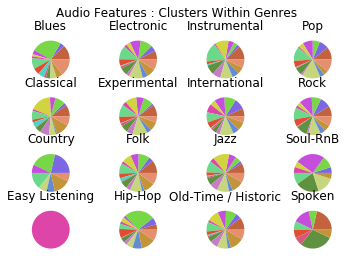

In [18]:
fig, sub = plt.subplots(4, 4)
index = 0

fig.suptitle('Audio Features : Clusters Within Genres')

for genre, data in audio_genre_clusters.groupby('genre'):
    cluster_colors = [colors[num] for num in data.cluster]
    
    row = index % 4
    col = int(index / 4)
    index += 1
    
    sub[row, col].set_title(genre)
    sub[row, col].pie(data.ammount, colors=cluster_colors)

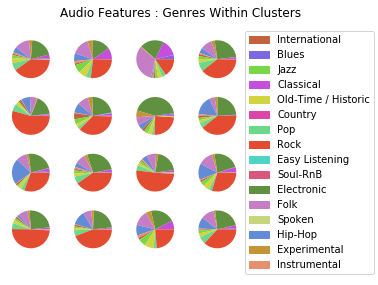

In [19]:
fig, sub = plt.subplots(4, 6, figsize=(6.5, 4))
index = 0

fig.suptitle('Audio Features : Genres Within Clusters')

for ax in sub.flat:
    ax.axis('off')

patches = [mpatches.Patch(color=color, label=genre) for genre, color in genre_colors.items()]
fig.legend(handles=patches, bbox_to_anchor=(0.81, 0.9))

for cluster, data in audio_genre_clusters.groupby('cluster'):
    pie_colors = [genre_colors[genre] for genre in data.genre]
    row = index % 4
    col = int(index / 4)
    index += 1
    
    sub[row, col].pie(data.ammount, colors=pie_colors)

In [20]:
# ---------- Unsupervised Learning On Temporal Features ----------
# echonest_with_genres = shuffle(echonest[pd.notnull(echonest.genre)])
echonest_with_genres = shuffle(echonest[pd.notnull(echonest.genre)])

temporal_training_data = echonest_with_genres.audio_features.values

kmeans_audio = KMeans(n_clusters=len(artist_genre_counts)).fit(temporal_training_data)
temporal_clusters = kmeans_audio.predict(temporal_training_data)

In [21]:
# The Genre Clusters Count
temporal_genres = echonest_with_genres.genre.copy().reset_index(drop=True)
temporal_genre_clusters = pd.DataFrame([temporal_genres, temporal_clusters], index=['genre', 'cluster']).transpose()

# Aggregate the table data
temporal_genre_clusters = temporal_genre_clusters.groupby(['genre', 'cluster']).size().reset_index()
temporal_genre_clusters.rename(columns={ 0 :  'ammount'}, inplace=True)

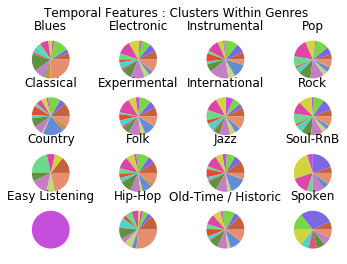

In [22]:
fig, sub = plt.subplots(4, 4)
index = 0

fig.suptitle('Temporal Features : Clusters Within Genres')

for genre, data in temporal_genre_clusters.groupby('genre'):
    cluster_colors = [colors[num] for num in data.cluster]
    row = index % 4
    col = int(index / 4)
    index += 1
    
    sub[row, col].set_title(genre)
    sub[row, col].pie(data.ammount, colors=cluster_colors)

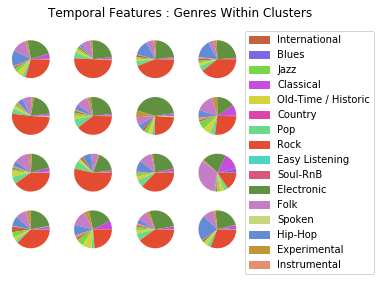

In [23]:
fig, sub = plt.subplots(4, 6, figsize=(6.5, 4))
index = 0

fig.suptitle('Temporal Features : Genres Within Clusters')

for ax in sub.flat:
    ax.axis('off')

patches = [mpatches.Patch(color=color, label=genre) for genre, color in genre_colors.items()]
fig.legend(handles=patches, bbox_to_anchor=(0.81, 0.9))

for cluster, data in temporal_genre_clusters.groupby('cluster'):
    pie_colors = [genre_colors[genre] for genre in data.genre]
    
    row = index % 4
    col = int(index / 4)
    index += 1
    
    sub[row, col].pie(data.ammount, colors=pie_colors)